In [2]:
#from mpi4py import MPI 
import netket as nk
import netket.experimental as nkx
import nqs.BeH2_ptutorial as bpm
import pickle
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# get data to build the qubit Hamiltonian for BeH2
pauli_list   = np.load('../data/tomography/BeH2/paulis.file',allow_pickle=True)
interactions = np.load('../data/tomography/BeH2/interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIIIII  | Interaction: -1.707E+01
Pauli: ZIIIII  | Interaction: 1.156E-01
Pauli: XXZIII  | Interaction: 7.270E-03
Pauli: YYIIII  | Interaction: 7.270E-03
Pauli: ZZIIII  | Interaction: 1.000E-01
Pauli: ZXXIII  | Interaction: -4.618E-03
Pauli: IYYIII  | Interaction: -4.618E-03
Pauli: IZZIII  | Interaction: -1.599E-01
Pauli: IIZIII  | Interaction: -3.908E-01
Pauli: IIIZII  | Interaction: 1.156E-01
...


In [4]:
# Define some parameters + get paths to data

N = 6          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.01      # Learning rate
M = 20000      # Number of samples for the negative CD phase
bs = 10000     # Batch size
epochs = 300   # Epochs
n_train_samples= 1000 # start with smalll number before using ns

samples_path = "../data/tomography/BeH2/train_samples.txt"
bases_path = "../data/tomography/BeH2/train_bases.txt"
pauli_path = "../data/tomography/BeH2/paulis.file"
interactions_path = "../data/tomography/BeH2/interactions.file"
ed_energy = float(np.loadtxt("../data/tomography/BeH2/energy.txt"))
psi0 = np.loadtxt("../data/tomography/BeH2/psi.txt")

In [5]:
# build rbm + sampler + driver etc -- start with Hamiltonian first

# Hilbert space
hi = nk.hilbert.Qubit(N=6)
# NetKet Hamiltonian
hamiltonian = bpm.BuildHamiltonian(N,hi,pauli_path,interactions_path)

In [6]:
# After building Hamiltonian, check it:
print("\n=== HAMILTONIAN CHECK ===")
print(f"Hamiltonian type: {type(hamiltonian)}")
print(f"Hamiltonian dtype: {hamiltonian.dtype}")

# Try to compute energy on a random state
test_state = np.random.randn(2**N) + 1j * np.random.randn(2**N)
test_state = test_state / np.linalg.norm(test_state)

# Manual energy calculation
H_matrix = hamiltonian.to_dense()  # Get full matrix
test_energy = np.vdot(test_state, H_matrix @ test_state).real
print(f"Test energy on random state: {test_energy}")
print(f"ED ground state energy: {ed_energy}")


=== HAMILTONIAN CHECK ===
Hamiltonian type: <class 'netket.operator._local_operator.jax.LocalOperatorJax'>
Hamiltonian dtype: complex128
Test energy on random state: -17.062212719860852
ED ground state energy: -19.038795049423


In [7]:
# Another check to make sure we can actually get that ground state

# Get the Hamiltonian as a dense matrix
H_matrix = hamiltonian.to_dense()

print("\n=== HAMILTONIAN ANALYSIS ===")
print(f"Hamiltonian shape: {H_matrix.shape}")
print(f"Is Hermitian? {np.allclose(H_matrix, H_matrix.conj().T)}")

# Get eigenvalues + eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
print(f"\nLowest 5 eigenvalues:")
print(eigenvalues[:5])
print(f"Highest 5 eigenvalues:")
print(eigenvalues[-5:])

print(f"\nED ground state energy: {ed_energy}")
print(f"Hamiltonian ground state: {eigenvalues[0]}")

ground_state = eigenvectors[:, 0]
print(f"\nGround state eigenvector shape: {ground_state.shape}")

# get exact ground state and compare with the one they got:
print("Overlap between the gs calculated here and the one they got:",np.dot(ground_state,psi0))


=== HAMILTONIAN ANALYSIS ===
Hamiltonian shape: (64, 64)
Is Hermitian? True

Lowest 5 eigenvalues:
[-19.03879505 -18.57708276 -18.53549258 -18.38773058 -18.38068849]
Highest 5 eigenvalues:
[-15.90826383 -15.64704217 -15.64704217 -15.06263444 -13.72257779]

ED ground state energy: -19.038795049423
Hamiltonian ground state: -19.038795049422998

Ground state eigenvector shape: (64,)
Overlap between the gs calculated here and the one they got: (1.0000000000000007+0j)


In [8]:
# train rbm

# Load training data
rotations, tr_samples, tr_bases = bpm.LoadData(N,hi,samples_path, bases_path)
if (ns > tr_samples.shape[0]):
    "Not enough training samples"
else:
    training_samples = tr_samples[0:ns]
    training_bases   = tr_bases[0:ns]
    
# load bases using new function:
Us = bpm.load_bases(bases_path)

Loaded 128000 measurement bases from ../data/tomography/BeH2/train_bases.txt
Number of qubits: 6
Unique bases: 54


In [ ]:
# RBM wavefunction
ma = nk.models.RBM(alpha=1)        # Complex-weights RBM, alpha=num_hidden/N
# Sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# Optimizer + Stochastic Reconfiguration -- works better but first try SGD
op = nk.optimizer.RmsProp(learning_rate=lr,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR()

# Stochastic gradient descent optimizer
op = nk.optimizer.Sgd(learning_rate=5e-2)

In [10]:
# define the variational state - specifiy the sampler and the model to sample from
vs = nk.vqs.MCState(
    sampler=sa,
    model=ma,
    n_samples=M,
)

# let's see it now
vs

MCState(
  hilbert = Qubit(N=6),
  sampler = MetropolisSampler(rule = LocalRule(), n_chains = 16, sweep_size = 6, reset_chains = False, machine_power = 2, dtype = int8),
  n_samples = 20000,
  n_discard_per_chain = 5,
  sampler_state = MetropolisSamplerState(rng state=[3645584616 2197293628]),
  n_parameters = 48)

In [11]:
# build a driver to manage the optimisation loop
qst = nkx.QSR(training_data=(tr_samples[:ns],Us[:ns]),
              training_batch_size=bs,
              optimizer=op,
              variational_state=vs,
              #preconditioner=sr,
              seed=42)

In [12]:
# object to log the details of training 
logger = nk.logging.RuntimeLog()

In [13]:
# # Training loop
fidelity = []
for ep in qst.iter(epochs+1, 10):
    # Get energy measurement
    obs = qst.estimate(hamiltonian) # <psi_lambda|H|psi_lambda>
    # Compute overlap with exact state
    psi_ma = qst.state.to_array()
    overlap = np.abs(np.vdot(psi_ma, psi0))
    fidelity.append(overlap**2)
    rbm_energy = obs.mean.real
    print('Epoch = %d   ' % ep,end='')
    print('Fidelity = %.6f   '% fidelity[-1],end='')
    print("<H> = %.8f" % rbm_energy,end=" | ")
    print("ED = %.8f" % ed_energy)

Epoch = 0   Fidelity = 0.014878   <H> = -16.91962987 | ED = -19.03879505
Epoch = 10   Fidelity = 0.012003   <H> = -16.80096100 | ED = -19.03879505
Epoch = 20   Fidelity = 0.007470   <H> = -16.65799483 | ED = -19.03879505
Epoch = 30   Fidelity = 0.001515   <H> = -16.52711864 | ED = -19.03879505
Epoch = 40   Fidelity = 0.000029   <H> = -16.58723370 | ED = -19.03879505
Epoch = 50   Fidelity = 0.000486   <H> = -16.69210724 | ED = -19.03879505
Epoch = 60   Fidelity = 0.000800   <H> = -16.75248562 | ED = -19.03879505
Epoch = 70   Fidelity = 0.000984   <H> = -16.78014187 | ED = -19.03879505
Epoch = 80   Fidelity = 0.001098   <H> = -16.80217789 | ED = -19.03879505
Epoch = 90   Fidelity = 0.001179   <H> = -16.82173080 | ED = -19.03879505
Epoch = 100   Fidelity = 0.001232   <H> = -16.83080374 | ED = -19.03879505
Epoch = 110   Fidelity = 0.001273   <H> = -16.83413654 | ED = -19.03879505
Epoch = 120   Fidelity = 0.001306   <H> = -16.84702033 | ED = -19.03879505
Epoch = 130   Fidelity = 0.001331   

In [14]:
# check that the driver is actually doing the correct estimation

# During training, after an epoch:
obs = qst.estimate(hamiltonian)
rbm_energy = obs.mean.real

# Also compute it manually:
psi_rbm = vs.to_array()  # Get RBM wavefunction
H_matrix = hamiltonian.to_dense()
manual_energy = np.vdot(psi_rbm, H_matrix @ psi_rbm).real / np.vdot(psi_rbm, psi_rbm).real

print(f"qst.estimate energy: {rbm_energy}")
print(f"Manual energy: {manual_energy}")
print(f"RBM norm: {np.linalg.norm(psi_rbm)}")

qst.estimate energy: -16.8820494343097
Manual energy: -16.884519905875955
RBM norm: 1.0


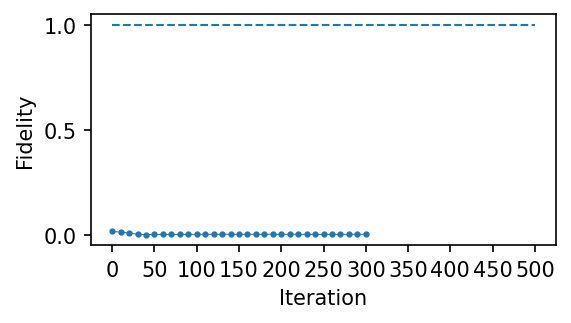

In [15]:
fig = plt.figure(1,figsize=(4,2), dpi=150, facecolor='w', edgecolor='k')

plt.plot(fidelity,linewidth=0.5,marker='o',markersize=2)
plt.xlabel("Iteration",fontsize=10)
plt.ylabel("Fidelity",fontsize=10)
plt.yticks([0.0,0.5,1.0],fontsize=10)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50],[0,50,100,150,200,250,300,350,400,450,500],fontsize=10)
plt.hlines(1.0,xmin=0,xmax = 50,linewidth=1.0,linestyle="--")

plt.show()